# Low Density Parity Check (LDPC) Codes in 5G
5G networks uses low density parity check codes (ldpc) for forward error correction of shared channels used to communicate user data over air interface. These channel codes:

- achieve channel capacity for large block lengths
- extremely robust against noise
- scalable and efficient hardware implementation.
- Low power consumption and silicon footprint.
- Can be enhanced to support diverse payload sizes and code-rates.
- easy to design and implement the low complexity decoder.
- capable of considering both reliability and high data rates.

The table of content of this tutorial is illustrated below:

* [Import Libraries](#import-libraries)
* [Symbol Mapping Configurations](#symbol-mapping-configurations)
* [Simulation for BER vs SNR](#simulation-awgn-channel)
    * BER vs SNR for fixed block-rate.
    * BER vs SNR for fixed code rate.
* [LDPC Parameters](#ldpc-parameters)
* [Performance Evaluation](#performance-evaluation)


## Import Libraries
### Python LIbraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import numpy as np

### 5G Toolkit Libraries

In [2]:
from toolkit5G.SymbolMapping import Demapper
from toolkit5G.SymbolMapping import Mapper
from toolkit5G.ChannelCoder  import LDPCEncoder5G
from toolkit5G.ChannelCoder  import LDPCDecoder5G
from toolkit5G.ChannelCoder.LDPC  import LDPCparameters
from toolkit5G.Ratematcher.LDPC  import BitSelection
from toolkit5G.Ratematcher.LDPC  import BitDeselection

In [3]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

## Symbol Mapping Configurations
Symbol mapping/Demapping is performed for:

- **QPSK** constellation defined by ``constellation_type`` which encodes
- 1 bit per contellation symbol defined by ``num_bits_per_symbol``.
- The demapper generates log likelihood ratios configured by ``hard_out`` 
- using a Log-Map (**"app"**) decoder defined using ``demapping_method``.

The flow of the implementation can be understood using folowing diagram:
![LDPCCodes](LDPC.png)

In [4]:
constellation_type  = "qam"
num_bits_per_symbol = 2
hard_out            = False
demapping_method    = "app"

mapper  = Mapper(constellation_type, num_bits_per_symbol)
demapper= Demapper(demapping_method, constellation_type,  num_bits_per_symbol, hard_out = hard_out)

## Simulation: *Variation in Reliability with code-rate for fixed block-length* 
### LDPC Parameters

- ``tbSize``: Defines the transport block size to be processed by LDPC Channel coder.
- ``codeRate``: codeRate of LDPC codec.
- ``lpdcConfig``: LDPC configuration is used to generate the  LDPC parameters. as described below.
- ``k``: Number of information bits to be encoded.
- ``bg``: Base graph type.
- ``zc``: Lifting factor size.
- ``numCBs``: Number of codeblocks.

<div class="alert-warning">
Note: tbSize and block length are different in LDPC codes. The length of block encoded using LDPC is given by K.
</div>

<br/>


### Simulation Procedure
This subsection performs the simulation which involve following steps:

* Computation of LDPC parameters based on ``tbSize`` and ``codeRate``.
* Bits tensor generation of dimension ``numBatches`` $\times$ ``numCBs`` $\times$ ``k``.
* LDPC Encoding.
* Rate matching
    * Bit-Selection
    - Bit-Interleaving
* QPSK Symbol Mapping of encoded bits.
* Passing through the AWGN Channel
    * Adding noise to BPSK symbols with a given SNR
* Symbol De-mapping using **Log Map** Demapper defined by  ``"app"``.
    * Generates Log likelihood values as ``hard_out`` is set to ``False``.
* De-rate matching
    * Bit-Deselection
    - Bit-Deinterleaving
* LDPC Decoding
* BER computation

The flow of the implementation can be understood using folowing diagram:
![LDPCCodes](LDPC.png)

The bit error rate (BER) is computed for every combination of code-rate $= \{0.33, 0.4, 0.5, 0.67, 0.75, 0.83, 0.89\}$ and SNR $= \{-5 , -2.5,  0 ,  2.5,  5\}$ dB.

In [5]:
tbSize     = 32
numBatches = 100

codeRate   = np.array([0.33, 0.5, 0.75, 0.89])
SNRdB      = np.linspace(-5,5,5)
SNR        = 10**(0.1*SNRdB)


BER        = np.zeros((codeRate.size, SNRdB.size))
rIndex     = 0
snrIndex   = 0

for coderate in codeRate:
    lpdcConfig = LDPCparameters(tbSize, coderate)
    k          = lpdcConfig.k_ldpc

    bg         = lpdcConfig.baseGraph
    zc         = lpdcConfig.liftingfactor
    numCBs     = lpdcConfig.numCodeBlocks
    N          = lpdcConfig.n

    bits       = np.float32(np.random.randint(2, size = (numBatches, numCBs, k), dtype=np.int8))
    encoder    = LDPCEncoder5G(k, bg, zc)
    encBits    = encoder(bits)
    E          = int(k/coderate)
    rateMatch  = BitSelection(numLayers=1, modOrder=2, numCodedBits=E, baseGraph=bg, enableLBRM=False, tbSize=tbSize, numCBs=numCBs)
    codeword   = rateMatch(encBits, rvID=0)
    symbols    = mapper(codeword[0])
    snrIndex   = 0
    for snr in SNR:

        symbs      = symbols + np.sqrt(0.5/snr)*(np.random.standard_normal(size=symbols.shape)+1j*np.random.standard_normal(size=symbols.shape)).astype(np.complex64)

        llrs       = demapper([symbs , np.float32(1/snr)])

        rxCodeword = BitDeselection(np.array([]), bg, zc, False)([llrs], rvID=0)
        decoder    = LDPCDecoder5G(bg, zc)
        decBits    = decoder(rxCodeword)
        BER[rIndex, snrIndex] = np.mean(np.abs(decBits-bits))
        print("For coderate="+str(coderate)+" ("+str(k/codeword[0].shape[-1])+"), At SNR(dB): "+str(SNRdB[snrIndex])+" | Bit Error Rate: "+str(BER[rIndex, snrIndex]))
        snrIndex += 1
    rIndex   += 1


For coderate=0.33 (0.3305785123966942), At SNR(dB): -5.0 | Bit Error Rate: 0.31212499737739563
For coderate=0.33 (0.3305785123966942), At SNR(dB): -2.5 | Bit Error Rate: 0.20225000381469727
For coderate=0.33 (0.3305785123966942), At SNR(dB): 0.0 | Bit Error Rate: 0.017000000923871994
For coderate=0.33 (0.3305785123966942), At SNR(dB): 2.5 | Bit Error Rate: 0.0
For coderate=0.33 (0.3305785123966942), At SNR(dB): 5.0 | Bit Error Rate: 0.0
For coderate=0.5 (0.5), At SNR(dB): -5.0 | Bit Error Rate: 0.31687501072883606
For coderate=0.5 (0.5), At SNR(dB): -2.5 | Bit Error Rate: 0.2605000138282776
For coderate=0.5 (0.5), At SNR(dB): 0.0 | Bit Error Rate: 0.15962499380111694
For coderate=0.5 (0.5), At SNR(dB): 2.5 | Bit Error Rate: 0.0043750000186264515
For coderate=0.5 (0.5), At SNR(dB): 5.0 | Bit Error Rate: 0.0
For coderate=0.75 (0.7547169811320755), At SNR(dB): -5.0 | Bit Error Rate: 0.328000009059906
For coderate=0.75 (0.7547169811320755), At SNR(dB): -2.5 | Bit Error Rate: 0.286749988794

## Performance Evaluation: BER vs SNR for different code-rates
The script plots SNR in dB vs BER performance at code-rate $= \{0.33, 0.4, 0.5, 0.67, 0.75, 0.83, 0.89\}$. It can be observed that the Reed Muller codes can provide the reliablilty of 

- $99.99990 \text{ or BER = } 10^{-4}$ for coderate $\leq 0.5$  at an SNR value $\leq 5$dB. 
- For higher coderates higher SNR values are required to achieve the same performance.

Furthermore, the following averaged over $500000$ batches (monteCarloIterations).

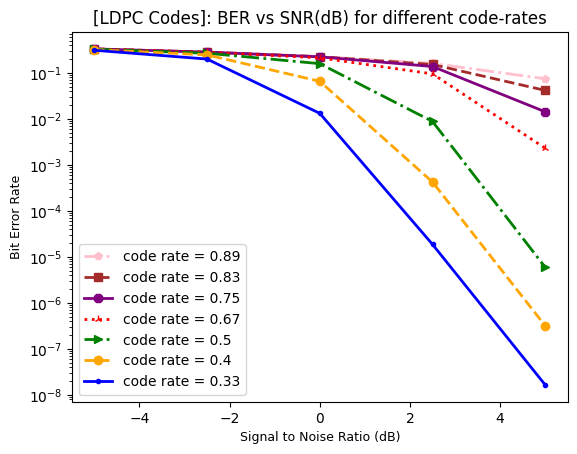

In [6]:
fig, ax = plt.subplots()

color_tuple     = ['blue', 'orange', 'green',   'red',    'purple', 'brown',       'pink',  'gray', 'olive', 'cyan', 'black']
markcolor_tuple = ['gold', 'navy',   'crimson', 'yellow', 'line',   'springgreen', 'black', 'aqua', 'royalblue', 'red', 'green']
linestyle_tuple = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']
marker_tuple    = [".", "o", ">", "2", "8", "s", "p", "*", "P", "X", "D"]

rIndex = codeRate.size-1
for coderate in np.flip(codeRate):
    ax.semilogy(SNRdB, BER[rIndex], color=color_tuple[rIndex%len(color_tuple)], 
                linestyle=linestyle_tuple[rIndex%len(linestyle_tuple)], lw = 2,
                marker=marker_tuple[rIndex%len(marker_tuple)], markersize = 6, label="code rate = "+str(coderate))
    
    rIndex = rIndex - 1

ax.legend(loc="lower left")
ax.set_xlabel("Signal to Noise Ratio (dB)", fontsize = 9)
ax.set_ylabel("Bit Error Rate", fontsize = 9)
ax.set_title("[LDPC Codes]: BER vs SNR(dB) for different code-rates", fontsize = 12)
plt.rcParams.update({'font.size': 9})
plt.show()

## Simulation: *Variation in Reliability with block-length for fixed coderate* 

In [7]:
tbSize     = np.array([32, 128, 512, 2048, 8192])
numBatches = 100

codeRate   = np.array([0.5])
SNRdB      = np.linspace(-5,5,5)
SNR        = 10**(0.1*SNRdB)

BER        = np.zeros((tbSize.size, SNRdB.size))
rIndex     = 0
snrIndex   = 0
tbIndex    = 0

for tbsize in tbSize:
    rIndex     = 0
    for coderate in codeRate:
        lpdcConfig = LDPCparameters(tbsize, coderate)
        k          = lpdcConfig.k_ldpc

        bg         = lpdcConfig.baseGraph
        zc         = lpdcConfig.liftingfactor
        numCBs     = lpdcConfig.numCodeBlocks
        N          = lpdcConfig.n

        bits       = np.float32(np.random.randint(2, size = (numBatches, numCBs, k), dtype=np.int8))
        encoder    = LDPCEncoder5G(k, bg, zc)
        encBits    = encoder(bits)
        E          = int(k/coderate)
        rateMatch  = BitSelection(numLayers=1, modOrder=2, numCodedBits=E, baseGraph=bg, enableLBRM=False, tbSize=tbSize, numCBs=numCBs)
        codeword   = rateMatch(encBits, rvID=0)
        symbols    = mapper(codeword[0])
        snrIndex   = 0
        for snr in SNR:

            symbs      = symbols + np.sqrt(0.5/snr)*(np.random.standard_normal(size=symbols.shape)+1j*np.random.standard_normal(size=symbols.shape)).astype(np.complex64)

            llrs       = demapper([symbs , np.float32(1/snr)])

            rxCodeword = BitDeselection(np.array([]), bg, zc, False)([llrs], rvID=0)
            decoder    = LDPCDecoder5G(bg, zc)
            decBits    = decoder(rxCodeword)
            BER[tbIndex, snrIndex] = np.mean(np.abs(decBits-bits))
            print("For tbsize="+str(tbsize)+" ("+str(k/codeword[0].shape[-1])+"), At SNR(dB): "+str(SNRdB[snrIndex])+" | Bit Error Rate: "+str(BER[tbIndex, snrIndex]))
            snrIndex += 1
        rIndex   += 1
    tbIndex   += 1


For tbsize=32 (0.5), At SNR(dB): -5.0 | Bit Error Rate: 0.31712499260902405
For tbsize=32 (0.5), At SNR(dB): -2.5 | Bit Error Rate: 0.273250013589859
For tbsize=32 (0.5), At SNR(dB): 0.0 | Bit Error Rate: 0.15049999952316284
For tbsize=32 (0.5), At SNR(dB): 2.5 | Bit Error Rate: 0.011749999597668648
For tbsize=32 (0.5), At SNR(dB): 5.0 | Bit Error Rate: 0.0
For tbsize=128 (0.5), At SNR(dB): -5.0 | Bit Error Rate: 0.3294583261013031
For tbsize=128 (0.5), At SNR(dB): -2.5 | Bit Error Rate: 0.26495832204818726
For tbsize=128 (0.5), At SNR(dB): 0.0 | Bit Error Rate: 0.16341666877269745
For tbsize=128 (0.5), At SNR(dB): 2.5 | Bit Error Rate: 0.0
For tbsize=128 (0.5), At SNR(dB): 5.0 | Bit Error Rate: 0.0
For tbsize=512 (0.5), At SNR(dB): -5.0 | Bit Error Rate: 0.3240416646003723
For tbsize=512 (0.5), At SNR(dB): -2.5 | Bit Error Rate: 0.26758334040641785
For tbsize=512 (0.5), At SNR(dB): 0.0 | Bit Error Rate: 0.15947222709655762
For tbsize=512 (0.5), At SNR(dB): 2.5 | Bit Error Rate: 0.0
Fo

## Performance Evaluation: BER vs SNR for different block lengths

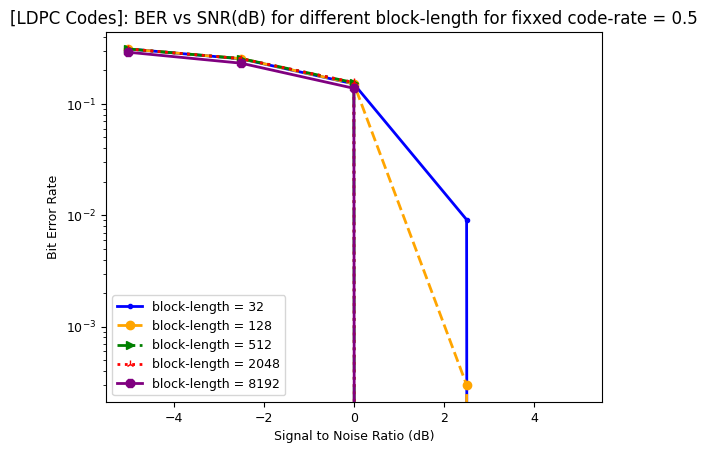

In [8]:
fig, ax = plt.subplots()

color_tuple     = ['blue', 'orange', 'green',   'red',    'purple', 'brown',       'pink',  'gray', 'olive', 'cyan', 'black']
markcolor_tuple = ['gold', 'navy',   'crimson', 'yellow', 'line',   'springgreen', 'black', 'aqua', 'royalblue', 'red', 'green']
linestyle_tuple = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']
marker_tuple    = [".", "o", ">", "2", "8", "s", "p", "*", "P", "X", "D"]

rIndex = 0
for tbsize in tbSize:
    ax.semilogy(SNRdB, BER[rIndex], color=color_tuple[rIndex%len(color_tuple)], 
                linestyle=linestyle_tuple[rIndex%len(linestyle_tuple)], lw = 2,
                marker=marker_tuple[rIndex%len(marker_tuple)], markersize = 6, label="block-length = "+str(tbsize))
    
    rIndex = rIndex + 1

ax.legend(loc="lower left")
ax.set_xlabel("Signal to Noise Ratio (dB)", fontsize = 9)
ax.set_ylabel("Bit Error Rate", fontsize = 9)
ax.set_title("[LDPC Codes]: BER vs SNR(dB) for different block-length for fixxed code-rate = 0.5", fontsize = 12)
plt.rcParams.update({'font.size': 9})
plt.show()